<a href="https://colab.research.google.com/github/Oks11111/TP_entrega_vpc2/blob/main/Clase_3_Tarea.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ejercicio Práctico - Clase 3 VPC2 - 4Co2021

1) Realizar transfer learning a partir de alguna de las siguientes redes: vgg11, resnet18, convnext_tiny preentrenadas, y entrenar sobre el dataset CIFAR10 contenido en PyTorch. Que puede concluir al compararlos con los resultados obtenidos en el entrenamiento de la tarea 2?

> El score unicial es mejor que en el caso anterior y no tiene sobreentrenamiento

2) Realice el entrenamiento de la misma red seleccionada en el punto 1, sin partir de pesos preentrenados en esta oportunidad y sin congelar capas. A que resultados llega y como los explica?

> Produce inconvenientes con memoria de cuda, los cuales no se solucionan con limpieza de cache. la única forma de rodearlo, según se aprecia, es usar batch. En este caso, si no se parte de pesos, se requiere entrenar para generar los pesos, lo cual tomaría mas tiempo. Por otro lado, si no se congelan las ultimas capas, no estamos adaptando la red neuronal a nuestro problema.


# Transfer Learning

Cuando realizamos Transfer Learning, tomamos un modelo ya entrenado con un conjunto de datos y utilizamos sus capas base para entrenar un nuevo modelo sobre otro dataset de interes. Dependiendo de la cantidad de datos y de lo diferentes que sean podremos evaluar como realizar dicho proceso de Transfer Learning.

Para este ejercicio, vamos a utilizar alguno de los modelos precargados en PyTorch para realizar Transfer Learning sobre el dataset de perros y gatos.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchsummary

!pip install torchmetrics
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 418 kB 8.0 MB/s 


Podemos descargar el dataset al entorno de trabajo, desde una carpea de en Drive a partir de utilizar el ID del archivo dentro de Drive

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
### Descripción del conjunto de entrenamiento ###
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
### Dimensiones de un ejemplo del dataset ###
(32, 32, 3)
### Descripción del conjunto de evaluación ###
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
Label de la imágen 0: 6
Label de la imágen 1: 9
Label de la imágen 2: 9
Label de la imágen 3: 4
Label de la imágen 4: 1
Label de la imágen 5: 1
Label de la imágen 6: 2
Label de la imágen 7: 7
Label de la imágen 8: 8


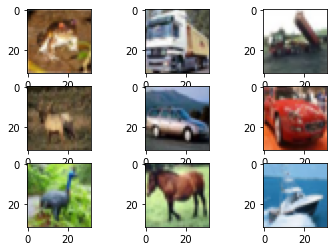

In [2]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

print("### Descripción del conjunto de entrenamiento ###")
print(train_set)
print("### Dimensiones de un ejemplo del dataset ###")
print(np.shape(train_set[0][0]))
print("### Descripción del conjunto de evaluación ###")
print(test_set)

# Ploteo algunas imagenes del dataset y sus etiquetas
for i in range(9):
  image, label = train_set[i]
  plt.subplot(331 + i)
  plt.imshow(image, cmap=plt.get_cmap('gray'))
  print("Label de la imágen {}: {}".format(i, label))

plt.show()

## Carga de datos con ImageDataGenerator

In [3]:
data_transforms = torchvision.transforms.Compose([
                    torchvision.transforms.Pad(padding=2),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # se utilizan media y desvio de la red
                  ])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=data_transforms)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=data_transforms)

valid_set_size = 10000

train_set, valid_set = torch.utils.data.random_split(train_set, [len(train_set) - valid_set_size, valid_set_size])

print("Tamaño del conjunto de entrenamiento: {}".format(len(train_set)))#
print("Tamaño del conjunto de validación: {}".format(len(valid_set)))
# Para la segunda parte de ejercicio se modifica el batch size de 32 a 10
train_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size=len(valid_set), shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set), shuffle=True)


Files already downloaded and verified
Files already downloaded and verified
Tamaño del conjunto de entrenamiento: 40000
Tamaño del conjunto de validación: 10000


## Carga de modelo base

Dentro de Keras, hay un modulo llamado [`applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=es-419), dentro del cual podemos encontrar algunos modelos de redes convolucionales, como los vistos en teoria, ya preentrenados y disponibles para descargar y utilizar. En este caso vamos a utilizar la arquitectura de VGG16 cuyos pesos fueron entrenados con el dataset ImageNet.

In [ ]:
vgg19_model = torchvision.models.vgg19(pretrained=True)

vgg19_model.to("cuda")

torchsummary.summary(vgg19_model, input_size=(3, 32, 32))
vgg19_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

## Congelo las capas de la red base

El primer paso para realizar Transfer Learning seria congelar las capas del modelo base seleccionado. Para hacer eso en PyTorch debemos poner en `False` la variable `requires_grad` de cada uno de los parametros que integran el modelo.

In [ ]:
for param in vgg19_model.parameters():
    param.requires_grad = False

Luego, en base a la arquitectura particular del modelo base, modificamos las capas que nosotros queremos, asignando una nueva capa, la cual, por defecto, tendra `requires_grad = True`

In [ ]:
#Reemplazamos la cantidad de clases que buscamos en la salida. En este casp cifar10 tiene 10 clases
last_layer_in_features = vgg19_model.classifier[-1].in_features
vgg19_model.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [ ]:
optimizer_ft = torch.optim.Adam(vgg19_model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [4]:
def train(model, criterion, optimizer, train_loader, valid_loader, epochs):

    accuracy_metric = torchmetrics.Accuracy()

    if torch.cuda.is_available():
        model.to("cuda")
        accuracy_metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:
            
            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data)
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = accuracy_metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data)
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += accuracy_metric(output, valid_target).item()
            
        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return model, history

In [ ]:
result_model, history = train(vgg19_model, criterion, optimizer_ft, train_loader, valid_loader, 20)

Epoch: 1/20 - Train loss 1.586014 - Train Accuracy 0.425800 - Valid Loss 1.373057 - Valid Accuracy 0.515300
Epoch: 2/20 - Train loss 1.399965 - Train Accuracy 0.494450 - Valid Loss 1.308684 - Valid Accuracy 0.535800
Epoch: 3/20 - Train loss 1.354636 - Train Accuracy 0.512650 - Valid Loss 1.278639 - Valid Accuracy 0.548700
Epoch: 4/20 - Train loss 1.328276 - Train Accuracy 0.520500 - Valid Loss 1.264016 - Valid Accuracy 0.552800
Epoch: 5/20 - Train loss 1.313353 - Train Accuracy 0.525025 - Valid Loss 1.254120 - Valid Accuracy 0.556500
Epoch: 6/20 - Train loss 1.305825 - Train Accuracy 0.528725 - Valid Loss 1.244075 - Valid Accuracy 0.557900
Epoch: 7/20 - Train loss 1.297248 - Train Accuracy 0.532450 - Valid Loss 1.241458 - Valid Accuracy 0.559300
Epoch: 8/20 - Train loss 1.292660 - Train Accuracy 0.535250 - Valid Loss 1.232881 - Valid Accuracy 0.565800
Epoch: 9/20 - Train loss 1.281255 - Train Accuracy 0.534700 - Valid Loss 1.232551 - Valid Accuracy 0.562100
Epoch: 10/20 - Train loss 1.

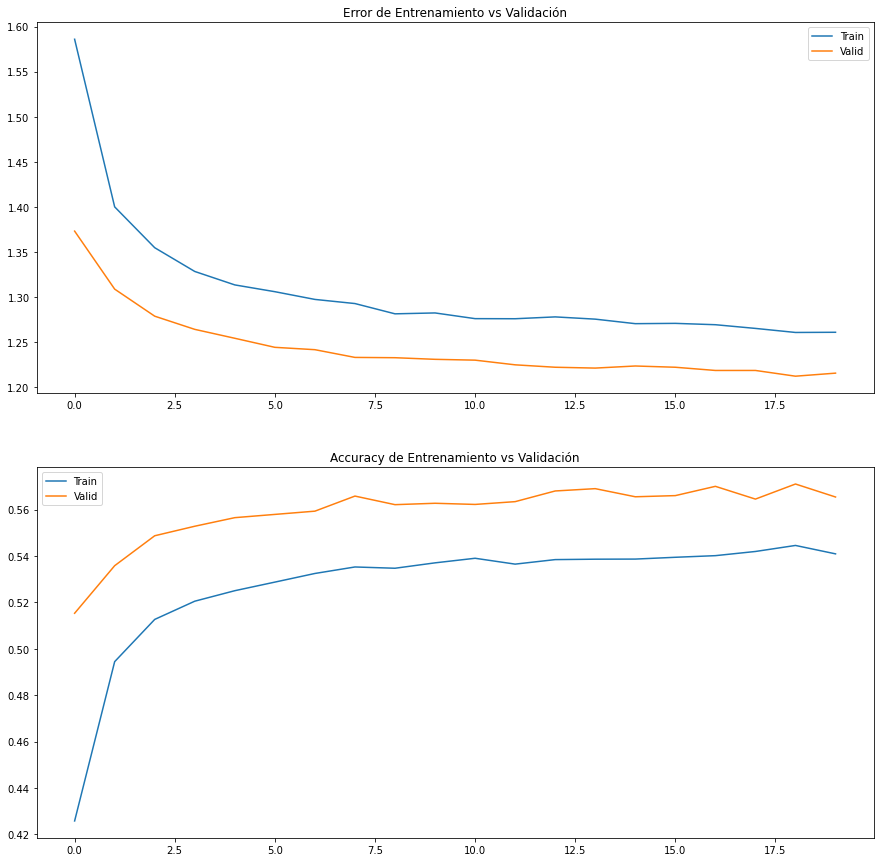

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación') 
axs[0].legend(['Train', 'Valid'])

axs[1].plot( history["train_acc"] ) 
axs[1].plot(history["valid_acc"]) 
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación') 
axs[1].legend(['Train', 'Valid'])

Para entrenar vgg19 sin utilizar los pesos preentrenados, modificamos:    

"vgg19_model = torchvision.models.vgg19(pretrained=False)"     

Tampoco vamos a usar la parte de codigo que indica que los gradientes no se calcularán:      
se mutea
"""for param in vgg19_model.parameters():
    param.requires_grad = False"""     


Debido a la cantidad de memoria reuqrida para alocar los calculos, obtenemos el siguiente error en colab:

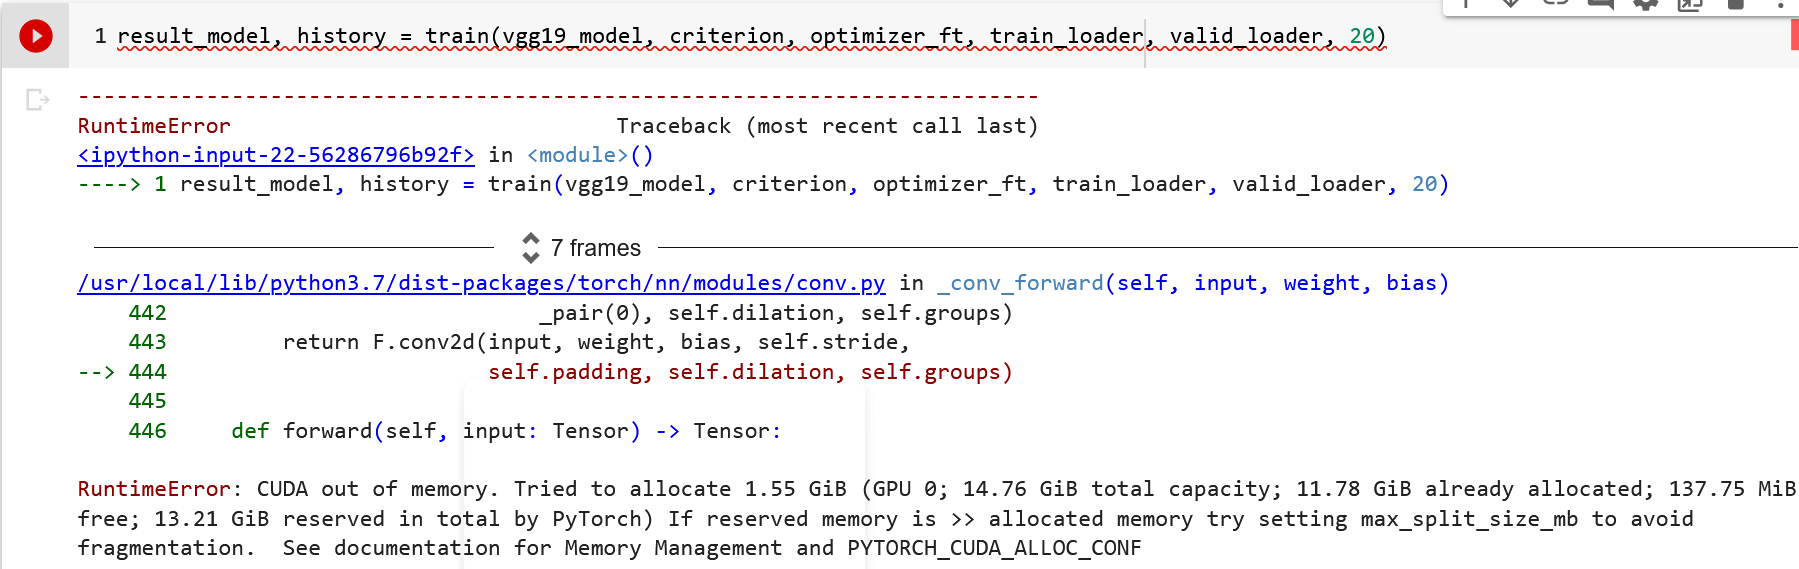

Cargamos modelo con False

In [5]:
torch.cuda.empty_cache()

In [6]:
vgg19_model_2 = torchvision.models.vgg19(pretrained=False)

vgg19_model_2.to("cuda")

torchsummary.summary(vgg19_model_2, input_size=(3, 32, 32))
vgg19_model_2.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

<bound method Module.modules of VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_

In [7]:
#Reemplazamos la cantidad de clases que buscamos en la salida. En este casp cifar10 tiene 10 clases
last_layer_in_features = vgg19_model_2.classifier[-1].in_features
vgg19_model_2.classifier[-1] = torch.nn.Linear(in_features=last_layer_in_features, out_features=10)

In [8]:
optimizer_ft = torch.optim.Adam(vgg19_model_2.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [9]:
result_model, history = train(vgg19_model_2, criterion, optimizer_ft, train_loader, valid_loader, 10)

RuntimeError: ignored